# Parameter evaulation

Before starting to explore a potential parameter space, the experimental setup parameters must be set:

In [2]:
# sample diameter
sample_diameter = 20e-03 # in m

# sample thickenss
sample_thickness = 1e-03 # in m

# downstream pipe diameter
downstream_pipe_diameter = 5e-03 # in m

# downstream pipe length
downstream_pipe_length = 2 # in m

From this the volume of the downstream section can be evaluated:

$$V = L \pi r^{2}$$

In [3]:
import numpy as np

r = downstream_pipe_diameter / 2
downstream_volume = downstream_pipe_length * np.pi * r ** 2 # in m3

print("Downstream volume = %.2e m3" % downstream_volume)

Downstream volume = 3.93e-05 m3


With this, the potential ranges of sample temperatures and upstream pressures for testing can be defined and festim simulations ran for each case

In [4]:
# sample temperatures varying between 450 and 750 K
test_temperature_values = np.linspace(450, 750, num=7)

# upstream pressure varying between 1e2 and 1e5 Pa
test_pressure_values = np.geomspace(1e2, 1e5, num=10)

From this one can invetigate how the range of sample temperatures and upstream pressures will influence the time it takes to reach a point of steady-state. 

For instance, taking a single case where the sample temperature is 700K and the upstream pressure is 1e5 Pa:

In [5]:
from festim_sim import festim_model_standard

festim_model_standard(
    T=700,
    pressure=1e5,
    foldername="results/",
    regime="diff",
    atol=1e8,
    final_time=5000,
    sample_thicnkess=sample_thickness
)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+03 s    Elapsed time so far: 1.5 s


Time to steady-state: 4039.67 s


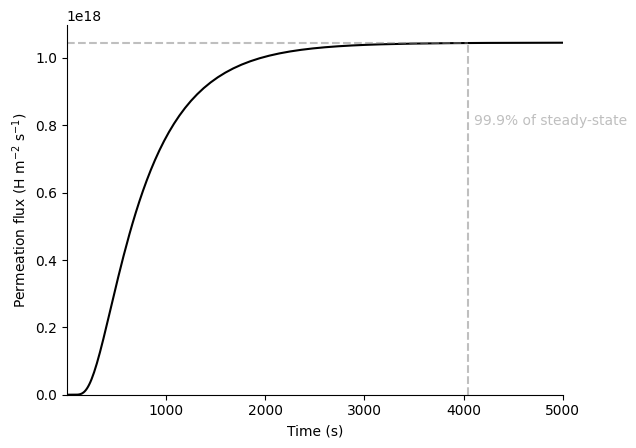

In [6]:
import matplotlib.pyplot as plt


run_data = np.genfromtxt(
    f"results/permeation_standard.csv",
    delimiter=",",
    names=True,
)
t = run_data["ts"]
surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1

time_to_steady_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
time_to_steady = t[time_to_steady_ind]

print(f"Time to steady-state: {time_to_steady:.2f} s")

plt.figure()
plt.plot(t, surface_flux, color="black")
plt.vlines(time_to_steady, 0, surface_flux[time_to_steady_ind], color="grey", linestyle="dashed", alpha=0.5)
plt.hlines(surface_flux[time_to_steady_ind], 0, time_to_steady, color="grey", linestyle="dashed", alpha=0.5)
plt.annotate("99.9% of steady-state", [4100, 0.8e18], ha="left", color="grey", alpha=0.5)
plt.xlabel(r"Time (s)")
plt.ylabel(r"Permeation flux (H m$^{-2}$ s$^{-1}$)")
plt.xlim(t[0], t[-1])
plt.ylim(bottom=0)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("downstream surface flux.svg")



From this is can be evaulated it took just over 4000s for the surface flux to reach a point of steady-state. 

Furthermore, with this result and the downstream parameters, the subsequent pressure rise in the downstream, $P_{\mathrm{down}}$, can be evaluated 

$$J_\mathrm{permeation}(t) = \frac{dP_{\mathrm{down}}}{dt} \frac{V}{A R_g T}$$

where $A$ is the cross sectional area of the sample, $V$ is the downstream volume, $R_g$ is the gas constant, and $T$ is the temperature.


This can be subsequently plotted:

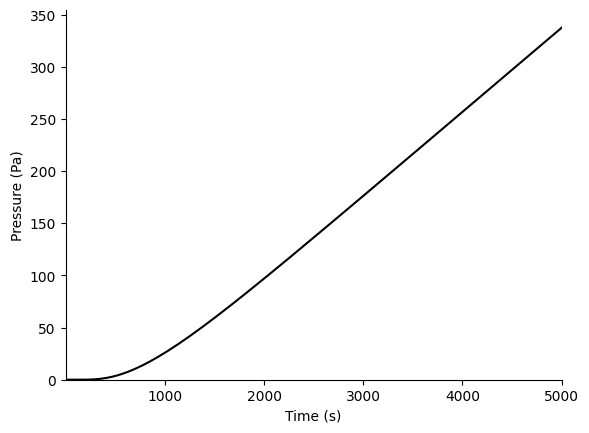

In [ ]:
from scipy.integrate import cumulative_trapezoid


def pressure_from_flux(flux, t, T):

    integrated_flux = cumulative_trapezoid(flux, t, initial=0)
    A = np.pi * (sample_diameter / 2) ** 2  # m^2
    n = integrated_flux * A / (6.022 * 10**23)  # number of hydrogen atoms in mols

    R = 8.314  # J/mol/K

    # Calculate pressure
    P = n * R * T / downstream_volume  # Pa

    return P

P_down = pressure_from_flux(flux=surface_flux, t=t, T=700)

plt.figure()
plt.plot(t, P_down, color="black")
plt.xlabel(r"Time (s)")
plt.ylabel(r"Pressure (Pa)")
plt.xlim(t[0], t[-1])
plt.ylim(bottom=0)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("downstream pressure rise.svg")



Varying the upstream pressure has no influence on the time it takes to reach a steady-state. However the temperature has a huge influence on this time:

In [8]:
# for pressure_value in test_pressure_values:
#     for temp_value in test_temperature_values:
#         print(f"Testing case P={pressure_value:.2e}, T={temp_value:.0f}")
#         festim_model_standard(
#             T=temp_value,
#             pressure=pressure_value,
#             foldername=f"results/parameter_exploration/P={pressure_value:.2e}/T={temp_value:.0f}",
#             regime="diff",
#             atol=1e08,
#             final_time=1e7,
#         )
        
# this can take a while to run, around 1m30 total

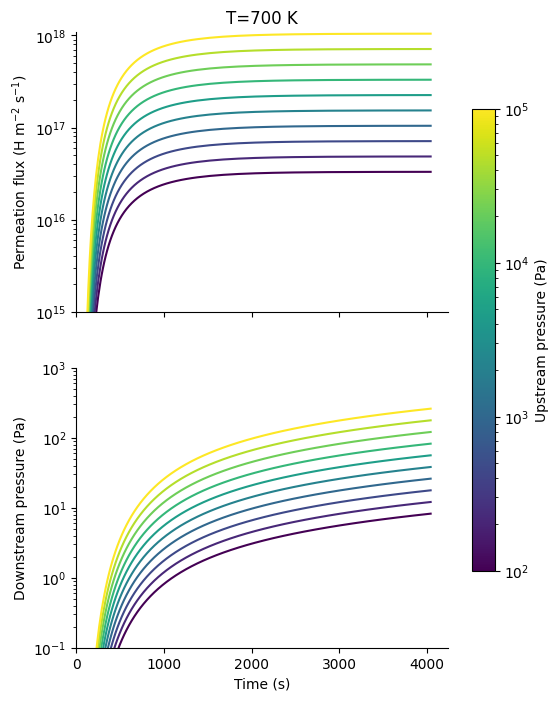

In [9]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm

P_data = []
t_data = []
surface_flux_data = []

for P_value in test_pressure_values:
    run_data = np.genfromtxt(
        f"results/parameter_exploration/P={P_value:.2e}/T=700/permeation_standard.csv",
        delimiter=",",
        names=True,
    )

    t = run_data["ts"]
    surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1

    time_to_steay_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
    t, surface_flux = t[:time_to_steay_ind], surface_flux[:time_to_steay_ind]

    P = pressure_from_flux(flux=surface_flux, t=t, T=700)

    P_data.append(P)
    t_data.append(t)
    surface_flux_data.append(surface_flux)

norm = LogNorm(vmin=min(test_pressure_values), vmax=max(test_pressure_values))
colorbar = cm.viridis
sm = plt.cm.ScalarMappable(cmap=colorbar, norm=norm)
colours = [colorbar(norm(i)) for i in test_pressure_values]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 8))

# Plot on the first axis
for colour, flux_values, t_values in zip(colours, surface_flux_data, t_data):
    axs[0].plot(t_values, flux_values, color=colour)
axs[0].set_ylabel(r"Permeation flux (H m$^{-2}$ s$^{-1}$)")
axs[0].set_ylim(bottom=1e15)
axs[0].set_yscale("log")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].set_title(r"T=700 K")

# Plot on the second axis
for colour, P_values, t_values in zip(colours, P_data, t_data):
    axs[1].plot(t_values, P_values, color=colour)
axs[1].set_ylabel(r"Downstream pressure (Pa)")
axs[1].set_xlabel(r"Time (s)")
# axs[1].set_xscale("log")
# axs[1].set_ylim(bottom=1e12)

axs[1].set_yscale("log")
axs[1].set_ylim(1e-01, 1e3)
axs[1].set_xlim(left=0)
# axs[1].set_ylim(bottom=0)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

fig.colorbar(sm, label=r"Upstream pressure (Pa)", ax=axs, shrink=0.75)

plt.savefig("downstream pressure varying P.svg")


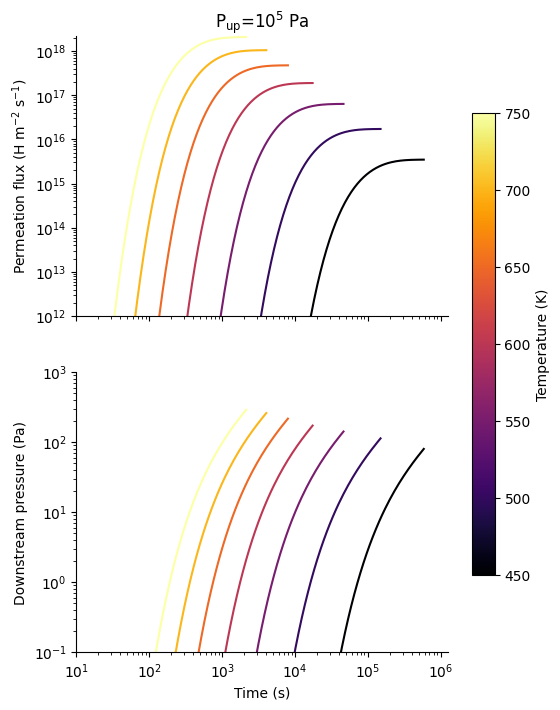

In [10]:

P_data = []
t_data = []
surface_flux_data = []

for T_value in test_temperature_values:
    run_data = np.genfromtxt(
        f"results/parameter_exploration/P=1.00e+05/T={T_value:.0f}/permeation_standard.csv",
        delimiter=",",
        names=True,
    )

    t = run_data["ts"]
    surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1

    time_to_steay_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
    t, surface_flux = t[:time_to_steay_ind], surface_flux[:time_to_steay_ind]

    P = pressure_from_flux(flux=surface_flux, t=t, T=T_value)

    P_data.append(P)
    t_data.append(t)
    surface_flux_data.append(surface_flux)

norm = Normalize(
    vmin=min(test_temperature_values), vmax=max(test_temperature_values)
)
colorbar = cm.inferno
sm = plt.cm.ScalarMappable(cmap=colorbar, norm=norm)
colours = [colorbar(norm(i)) for i in test_temperature_values]

normalised_fluxes = []
for fluxes in surface_flux_data:
    normalised_fluxes.append(fluxes / fluxes[-1])

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 8))

# Plot on the first axis
for colour, flux_values, t_values in zip(colours, surface_flux_data, t_data):
    axs[0].plot(t_values, flux_values, color=colour)
axs[0].set_ylabel(r"Permeation flux (H m$^{-2}$ s$^{-1}$)")
axs[0].set_ylim(bottom=1e12)
axs[0].set_yscale("log")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].set_title(r"P$_{\mathrm{up}}$=10$^{5}$ Pa")

# Plot on the second axis
for colour, P_values, t_values in zip(colours, P_data, t_data):
    axs[1].plot(t_values, P_values, color=colour)
axs[1].set_ylabel(r"Downstream pressure (Pa)")
axs[1].set_xlabel(r"Time (s)")
axs[1].set_xscale("log")
axs[1].set_xlim(left=1e1)
axs[1].set_yscale("log")
axs[1].set_ylim(1e-01, 1e3)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

fig.colorbar(sm, label=r"Temperature (K)", ax=axs, shrink=0.75)

plt.savefig("downstream pressure varying T.svg")


These results have been tapered at the time it took to reach 99.9% steady state.

The time to steady-state can be plotted:

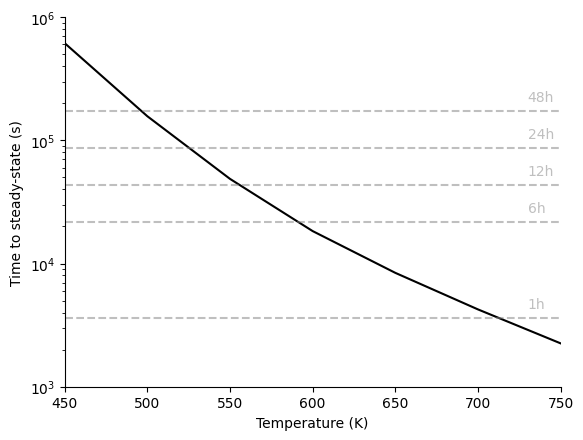

In [11]:
time_to_steady = []

for T_value in test_temperature_values:
    run_data = np.genfromtxt(
        f"results/parameter_exploration/P=1.00e+05/T={T_value:.0f}/permeation_standard.csv",
        delimiter=",",
        names=True,
    )
    t = run_data["ts"]
    surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1
    time_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
    time_to_steady.append(t[time_ind])

plt.figure()

plt.plot(test_temperature_values, time_to_steady, color="black")
plt.ylabel(r"Time to steady-state (s)")
plt.xlabel(r"Temperature (K)")
plt.yscale("log")
plt.xlim(450, 750)
plt.ylim(1e3, 1e6)
hour = 3600

for value in [1, 6, 12, 24, 48]:
    plt.hlines(
        y=hour * value,
        xmin=400,
        xmax=750,
        color="grey",
        alpha=0.5,
        linestyle="dashed",
    )
    plt.annotate(f"{value}h", xy=[730, hour * value * 1.2], color="grey", alpha=0.5)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("steady state times.svg")


From this it can be seen that sample temperatures below 500K could take more than 12h to reach a point of steady-state, meaning it may not be feasible to run an experiment at such temperatures.

Nevertheless the downstream pressure values can be plotted varying both pressure and temperture:

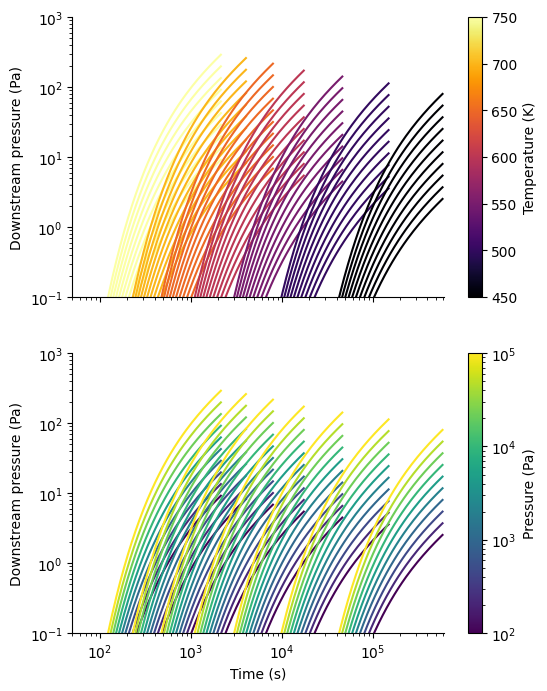

In [12]:
P_data = []
t_data = []

for P_value in test_pressure_values:
    P_data_per_pressure = []
    t_data_per_pressure = []
    for temp_value in test_temperature_values:
        run_data = np.genfromtxt(
            f"results/parameter_exploration/P={P_value:.2e}/T={temp_value:.0f}/permeation_standard.csv",
            delimiter=",",
            names=True,
        )

        t = run_data["ts"]
        surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1

        time_to_steay_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
        t, surface_flux = t[:time_to_steay_ind], surface_flux[:time_to_steay_ind]

        P = pressure_from_flux(flux=surface_flux, t=t, T=temp_value)

        P_data_per_pressure.append(P)
        t_data_per_pressure.append(t)

    P_data.append(P_data_per_pressure)
    t_data.append(t_data_per_pressure)

norm_T = Normalize(
    vmin=min(test_temperature_values), vmax=max(test_temperature_values)
)
colorbar_T = cm.inferno
sm_T = plt.cm.ScalarMappable(cmap=colorbar_T, norm=norm_T)
colours_T = [colorbar_T(norm_T(T)) for T in test_temperature_values]

norm_P = LogNorm(vmin=min(test_pressure_values), vmax=max(test_pressure_values))
colorbar_P = cm.viridis
sm_P = plt.cm.ScalarMappable(cmap=colorbar_P, norm=norm_P)
colours_P = [colorbar_P(norm_P(P)) for P in test_pressure_values]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 8))

# Plot on the first axis
for P_values, t_values in zip(P_data, t_data):
    for pressure, time, colour in zip(P_values, t_values, colours_T):
        axs[0].plot(time, pressure, color=colour)
axs[0].set_ylabel(r"Downstream pressure (Pa)")
axs[0].set_ylim(1e-01, 1e3)
axs[0].set_xlim(left=5e01)
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

# Plot on the second axis
for P_values, t_values, colour in zip(P_data, t_data, colours_P):
    for pressure, time in zip(P_values, t_values):
        axs[1].plot(time, pressure, color=colour)
axs[1].set_ylabel(r"Downstream pressure (Pa)")
axs[1].set_xlabel(r"Time (s)")
axs[1].set_ylim(1e-01, 1e3)
axs[1].set_xlim(left=5e01)
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

fig.colorbar(sm_T, label=r"Temperature (K)", ax=axs[0])
fig.colorbar(sm_P, label=r"Pressure (Pa)", ax=axs[1])

plt.savefig("downstream pressure varying T and P.svg")

However this isn't the easiest figure to extract data from, instead we can take the final pressure value from each run, where steady-state permeation flux has been achieved, for each temperature and pressure.

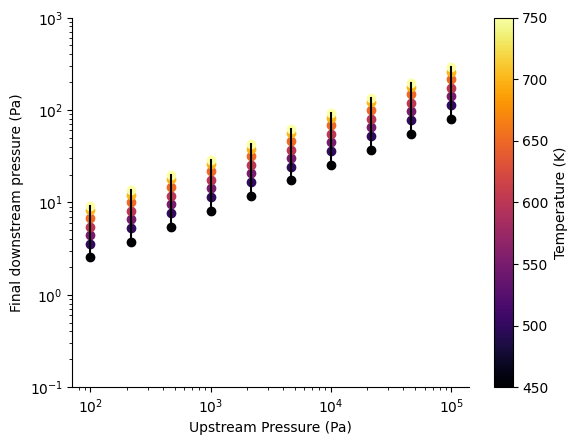

In [13]:
P_data = []

for P_value in test_pressure_values:
    P_data_per_pressure = []
    for temp_value in test_temperature_values:
        run_data = np.genfromtxt(
            f"results/parameter_exploration/P={P_value:.2e}/T={temp_value:.0f}/permeation_standard.csv",
            delimiter=",",
            names=True,
        )

        t = run_data["ts"]
        surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1

        time_to_steay_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
        t, surface_flux = t[:time_to_steay_ind], surface_flux[:time_to_steay_ind]

        P = pressure_from_flux(flux=surface_flux, t=t, T=temp_value)

        P_data_per_pressure.append(P[-1])

    P_data.append(P_data_per_pressure)

norm = Normalize(
    vmin=min(test_temperature_values), vmax=max(test_temperature_values)
)
colorbar = cm.inferno
sm = plt.cm.ScalarMappable(cmap=colorbar, norm=norm)
colours = [colorbar(norm(i)) for i in test_temperature_values]

plt.figure()
for P_up_values, P_down_values in zip(test_pressure_values, P_data):
    x = np.ones_like(P_down_values) * P_up_values
    plt.plot(x, P_down_values, color="black")
    for x_value, P_value, colour in zip(x, P_down_values, colours):
        plt.scatter(x_value, P_value, color=colour)

plt.xlabel("Upstream Pressure (Pa)")
plt.ylabel("Final downstream pressure (Pa)")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-01, 1e3)
# plt.xlim(left=1e1)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.colorbar(sm, label=r"Temperature (K)", ax=ax)
plt.savefig("final downstream pressure varying T and P.svg")


Here the range of final pressure values for runs with each upstream pressure and temperature is plotted in a black line also showing the temperature points coloured by value.

However, this is for the bare substrate case. We can modify the surface flux to estimate the pressure rises in the downstreamn when the sample is coated.

Furthemore, we can plot the operational range of different pressure gauges to see which may be appropriate to measure the pressure rise in the downstream with specific experiment parameters.

For this case we can consider a Baratron 1 Torr Absolute pressure transducer:

In [14]:
# pressure gauge range 1 Torr
Torr_model = 1

gauge_max = Torr_model * 133.3
# min detectable pressure 0.05% of full scale
gauge_min = 0.0005 * gauge_max


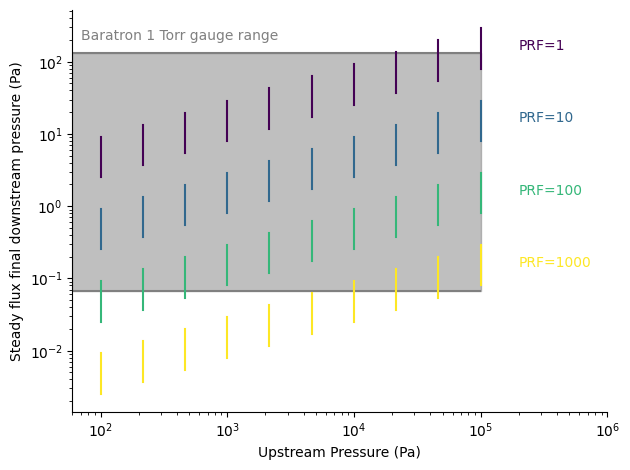

In [15]:
P_data = []
P_data_PRF_10 = []
P_data_PRF_100 = []
P_data_PRF_1000 = []

for P_value in test_pressure_values:
    P_data_per_pressure = []
    P_data_PRF_10_per_pressure = []
    P_data_PRF_100_per_pressure = []
    P_data_PRF_1000_per_pressure = []

    for temp_value in test_temperature_values:
        run_data = np.genfromtxt(
            f"results/parameter_exploration/P={P_value:.2e}/T={temp_value:.0f}/permeation_standard.csv",
            delimiter=",",
            names=True,
        )

        t = run_data["ts"]
        surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1

        time_to_steay_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
        t, surface_flux = t[:time_to_steay_ind], surface_flux[:time_to_steay_ind]

        P = pressure_from_flux(flux=surface_flux, t=t, T=temp_value)
        P_PRF_10 = pressure_from_flux(flux=surface_flux / 10, t=t, T=temp_value)
        P_PRF_100 = pressure_from_flux(flux=surface_flux / 100, t=t, T=temp_value)
        P_PRF_1000 = pressure_from_flux(flux=surface_flux / 1000, t=t, T=temp_value)

        P_data_per_pressure.append(P[-1])
        P_data_PRF_10_per_pressure.append(P_PRF_10[-1])
        P_data_PRF_100_per_pressure.append(P_PRF_100[-1])
        P_data_PRF_1000_per_pressure.append(P_PRF_1000[-1])

    P_data.append(P_data_per_pressure)
    P_data_PRF_10.append(P_data_PRF_10_per_pressure)
    P_data_PRF_100.append(P_data_PRF_100_per_pressure)
    P_data_PRF_1000.append(P_data_PRF_1000_per_pressure)

PRF_values = [1, 10, 100, 1000]
norm = LogNorm(vmin=min(PRF_values), vmax=max(PRF_values))
colorbar = cm.viridis
colours = [colorbar(norm(i)) for i in PRF_values]

x_values = np.geomspace(6e1, 1e5, num=100)

plt.figure()
plt.fill_between(x_values, gauge_min, gauge_max, color="grey", alpha=0.5)
plt.hlines(gauge_min, xmin=x_values[0], xmax=x_values[-1], color="grey")
plt.hlines(gauge_max, xmin=x_values[0], xmax=x_values[-1], color="grey")
plt.annotate(
    f"Baratron {Torr_model} Torr gauge range",
    xy=(x_values[2], gauge_max * 1.5),
    color="grey",
    ha="left",
)

for colour, data in zip(
    colours, [P_data, P_data_PRF_10, P_data_PRF_100, P_data_PRF_1000]
):
    for P_up_values, P_down_values in zip(test_pressure_values, data):
        x = np.ones_like(P_down_values) * P_up_values
        plt.plot(x, P_down_values, color=colour)
    plt.annotate(
        f"PRF={PRF_values[colours.index(colour)]}",
        xy=(2e5, data[-1][-1] * 0.5),
        color=colour,
    )

plt.xlabel("Upstream Pressure (Pa)")
plt.ylabel("Steady flux final downstream pressure (Pa)")
plt.xscale("log")
plt.yscale("log")
plt.xlim(6e1, 1e6)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("detectable pressure range.svg")